In [ ]:
"""
Purpose: Implementation fo DiffPool
graph coarsening manner

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
#sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/datasci_tools/datasci_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

from importlib import reload

In [3]:
data_path = Path("./data/m65_full/")
list(data_path.iterdir())

[PosixPath('data/m65_full/df_cell_type_fine_limbs_dist_thresh_exc.pbz2'),
 PosixPath('data/m65_full/df_morphometrics.pbz2'),
 PosixPath('data/m65_full/df_cell_type_fine_limbs.pbz2'),
 PosixPath('data/m65_full/cell_type_fine_with_skeleton_no_dense'),
 PosixPath('data/m65_full/cell_type_fine_no_dense'),
 PosixPath('data/m65_full/df_cell_type_fine_limbs_dist_thresh_inh.pbz2'),
 PosixPath('data/m65_full/df_cell_type_fine.pbz2')]

In [4]:
#datasci_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric import transforms

# for the dataset object
from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import DenseDataLoader

In [6]:
#pytorch_tools modules
import preprocessing_utils as pret
import geometric_models as gm

# Step 0: Choosing the Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

with_skeleton = True

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None


device = cpu


# Step 1: Loading the Graph Data

In [8]:
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"
dense_adj = False
directed = False

In [9]:
data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"[{'nodelist': ['L0_6'], 'features': ['mesh_vol...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
...,...,...,...,...,...,...,...
60448,864691137197334593,0,376218,LAYER_6,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...",NaN
60449,864691137197344065,0,191436,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...",NaN
60450,864691137197345345,0,584463,LAYER_2/3,RL,"[{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...",NaN
60451,864691137197353281,0,591241,LAYER_5,RL,"[{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...",NaN


In [10]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [11]:
data_df.query("cell_type_fine_label == cell_type_fine_label")

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
115,864691134884748026,0,366181,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...",4P
147,864691134884761338,0,458241,LAYER_4,RL,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",23P
170,864691134884769786,0,592718,LAYER_5,RL,"[{'nodelist': ['L0_18', 'L0_11', 'L0_17', 'L0_...",5P_IT
205,864691134884879610,0,304873,LAYER_5,V1,"[{'nodelist': ['L2_4', 'L1_1', 'L0_3', 'L1_6',...",IT_short
213,864691134884945146,0,63499,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",23P
...,...,...,...,...,...,...,...
60416,864691137197239105,0,262000,LAYER_4,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",4P
60417,864691137197241665,0,308938,LAYER_6,V1,"[{'nodelist': ['L1_4', 'L0_18', 'L4_1', 'L0_16...",Unsure
60433,864691137197306177,0,304611,LAYER_5,V1,"[{'nodelist': ['L0_1', 'L0_3', 'L0_6', 'L0_0',...",5P_NP
60442,864691137197321281,0,434601,LAYER_5,RL,"[{'nodelist': ['L0_3', 'L3_3', 'L2_2', 'L2_3',...",6P


In [12]:
data_dict = data_df[["cell_type_fine"]].iloc[1].to_list()[0][0]
data_dict

{'nodelist': array(['L0_1', 'L0_0', 'L0_2'], dtype=object),
 'features': array(['mesh_volume', 'n_spines', 'n_synapses_head', 'n_synapses_neck',
        'n_synapses_post', 'n_synapses_pre', 'skeletal_length',
        'total_spine_volume', 'width_upstream', 'width_downstream',
        'apical_label', 'basal_label', 'skeleton_vector_downstream_phi',
        'skeleton_vector_downstream_theta', 'skeleton_vector_upstream_phi',
        'skeleton_vector_upstream_theta', 'width_no_spine'], dtype=object),
 'adjacency': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]]),
 'feature_matrix': array([[ 3.71170715e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.43345470e+03,  0.00000000e+00,  5.91837642e+01,
          5.91837642e+01,  0.00000000e+00,  1.00000000e+00,
         -6.22637047e-01,  2.00297982e+00, -6.22637047e-01,
          2.00297982e+00,  5.91837642e+01],
        [ 2.99289539e+01,  0.00000000e+00,  0.00000000e+00,
    

# Step 2: Creating the Pytorch Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [13]:
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

# --- b) Creating the Dataset Class --

In [14]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [15]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [16]:
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True,
    features_to_delete=None,
    features_to_keep = None
    ): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds
    
    # --- keeping or not keeping sertain features
    gnn_features = gnn_info["features"]

    keep_idx = np.arange(len(gnn_features))
    if features_to_delete is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k not in features_to_delete])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER DELETE= {keep_idx}")
    if features_to_keep is not None:
        curr_idx = np.array([i for i,k in enumerate(gnn_features)
                       if k in features_to_keep])
        keep_idx = np.intersect1d(keep_idx,curr_idx)
        if verbose:
            print(f"keep_idx AFTER KEEP = {keep_idx}")

    x = x[:,keep_idx]

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)
    
    if len(y) > 1:
        raise Exception(f"y = {y}")
        
    if y.shape[0] != 1 or y.shape[1] != 1:
        raise Exception(f"y = {y}")


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data

In [17]:
class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        
        
        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y,
                features_to_delete=features_to_delete,
                features_to_keep = features_to_keep,
                verbose = False))

        if self.pre_filter is not None:
            data_list_final = []
            for data in data_list:
                try:
                    if self.pre_filter(data):
                        data_list_final.append(data)
                except:
                    continue
                    
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}")

        if self.pre_transform is not None:
            data_list_final = []
            for j,data in enumerate(data_list):
                try:
                    curr_t = self.pre_transform(data)
                    if curr_t.y.shape[0] != 1 or curr_t.y.shape[1] != 1:
                        raise Exception(f"{j}, data = {curr_t}")
                    data_list_final.append(curr_t)
                except:
                    continue
            data_list = data_list_final
            
        for j,d in enumerate(data_list):
            if d.y.shape[0] != 1 or d.y.shape[1] != 1:
                raise Exception(f"{j}, data = {d}")

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [18]:
if with_skeleton:
    gnn_task_name = f"{gnn_task}_with_skeleton"
else:
    gnn_task_name = f"{gnn_task}"

if dense_adj:
    processed_data_folder = data_path / Path(f"{gnn_task_name}")#_processed_dense")
elif directed:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_directed")#_processed_dense")
else:
    processed_data_folder = data_path / Path(f"{gnn_task_name}_no_dense")#_processed_dense")
    
# try:
#     su.rm_dir(processed_data_folder)
# except:
#     pass

processed_data_folder.mkdir(exist_ok = True)

In [19]:
max_nodes = np.max(all_batch_df_norm.index.to_numpy()) + 1

class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes
    
if dense_adj:
    #gets the maximum number of nodes in any of the graphs
    transform_list = [
        transforms.ToUndirected(),
        T.ToDense(max_nodes),
        #transforms.NormalizeFeatures(),
    ]
    pre_filter = MyFilter()
elif directed:
    transform_list = []
    pre_filter = None
else:
    transform_list = [
        transforms.ToUndirected(),
    ]
    
    pre_filter = None
    

transform_norm = transforms.Compose(transform_list)
dataset = CellTypeDataset(
        processed_data_folder.absolute(),
        pre_transform = transform_norm,
        pre_filter = pre_filter,
        )

Processing...


0it [00:00, ?it/s]

Done!


In [20]:
for j,d in enumerate(dataset):
    if d.y.shape[0] != 1 or d.y.shape[1] != 1:
        raise Exception(f"{j}")

In [21]:
dataset_num_node_features = dataset.num_node_features
dataset_num_classes = dataset.num_classes

In [22]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset_num_node_features}')
print(f'Number of classes: {dataset_num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Has isolated nodes: {data.has_isolated_nodes()}')
# print(f'Has self-loops: {data.has_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: CellTypeDataset(58948):
Number of graphs: 58948
Number of features: 14
Number of classes: 32

Data(x=[3, 14], edge_index=[2, 4], y=[1, 1])
Number of nodes: 3
Number of edges: 4
Average node degree: 1.33


# --- c) Splitting the Data into Labeled and unlabeled

In [23]:
labeled_mask = np.array(
    [True if k.y[0][0] > 0 else False for k in dataset]
).astype('int')
dataset_labeled = dataset[np.where(labeled_mask)[0]]
len(dataset_labeled)

3338

In [24]:
dataset_curr = dataset_labeled
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Train/Validation/Test

In [25]:
"""
Purpose: To turn percentages into raw lengths

"""

'\nPurpose: To turn percentages into raw lengths\n\n'

In [26]:
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset_curr,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

test size = 667.0 (0.2 %)
validation size = 667.0 (0.2 %)
train_size = 2004.0
data_lengths_with_train = [2004  667  667]
Number of training graphs: 2004
Number of test graphs: 667
Number of val graphs: 667


In [27]:
# # if wanted to try and add weights
# y_train = np.array([int(data.y[0][0].numpy()) for data in train_dataset])
# y_train_classes,y_train_count = np.unique(y_train,return_counts = True)
# y_train_classes,y_train_count

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# weight = {i:1/}
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [28]:
if dense_adj:
    data_loader_mod = DenseDataLoader
else:
    data_loader_mod = DataLoader


train_loader = data_loader_mod(train_dataset, batch_size=batch_size,shuffle = False)
test_loader = data_loader_mod(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = data_loader_mod(val_dataset, batch_size=batch_size,shuffle=False)

# Step 3a; Picking the Model

In [115]:
model_name = "GCN"
n_epochs = 100


import general_utils as gu
architecture_kwargs_global = dict(
    n_hidden_channels = 32, 
    #n_hidden_channels=64, 
    #first_heads=8, 
    #output_heads=1, 
    #dropout=0.6,
    global_pool_type="mean",
    n_layers = 2
)

optimizer_kwargs_global = dict(
    lr=0.01
)

all_run_kwargs = [
     dict(architecture_kwargs = {'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 2,"use_bn":False,
                                 "n_hidden_layers_classifier": 0}),
#     dict(architecture_kwargs = dict(n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 128),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 64),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 128),),
    
    
#     dict(architecture_kwargs = dict(n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_hidden_channels = 8,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 32,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 16,global_pool_type="add"),),
#     dict(architecture_kwargs = dict(n_layers = 1,n_hidden_channels = 8,global_pool_type="add"),),

]

# Step 3: Training the Model

In [116]:
import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [117]:
for j,config_dict in enumerate(all_run_kwargs):
    
    architecture_kwargs = config_dict.get("architecture_kwargs",dict())
    optimizer_kwargs = config_dict.get("optimizer_kwargs",dict())
    
    architecture_kwargs = gu.merge_dicts([architecture_kwargs_global.copy(),architecture_kwargs])
    optimizer_kwargs = gu.merge_dicts([optimizer_kwargs_global.copy(),optimizer_kwargs])
    
    run_kwargs = gu.merge_dicts([architecture_kwargs,optimizer_kwargs])

    
    if verbose:
        print(f"\n\n\n****------ Running Model Config {j} with following parameters ------****\n{run_kwargs}")

    model = getattr(gm,model_name)(
        dataset_num_node_features=dataset_num_node_features,
        dataset_num_classes=dataset_num_classes,
        **architecture_kwargs
        )

    optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
    print(model)


    
    # ---------------- Configuring the Tensorboard and Checkpoinns--------------------
    from torch.utils.tensorboard import SummaryWriter

    tensorboard_dir = Path("./tensorboard")
    tensorboard_dir.mkdir(exist_ok=True)
    tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
    tensorboard_dir.mkdir(exist_ok=True)

    tensorboard_file_name = (f'{model_name}_' 
                             + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
    tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
    print(f"tensorboard_file_name = {tensorboard_file_name}")
    tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
    try:
        su.rm_dir(tensorboard_file)
    except:
        pass
    tensorboard_file.mkdir(exist_ok = True)


    #-- when to save a checkpoint of the model
    checkpoint_dir = Path("./model_checkpoints")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
    checkpoint_dir.mkdir(exist_ok = True)
    checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

    try:
        su.rm_dir(checkpoint_path)
    except:
        pass

    checkpoint_path.mkdir(exist_ok = True)
    n_epoch_for_checkpoint = 5

    writer = SummaryWriter(tensorboard_file)
    

    print(model)


    # weights = weight#[0.1,0.5,,1,0.7,1,1,1]
    # class_weights = None
    class_weights = torch.FloatTensor(weights).to(device)

    tensor_map = None

    def train():
        model.train()

        for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
            #print(f"data = {data}")
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)
            y_true = data.y.squeeze_()
            #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
            loss = F.nll_loss(
                torch.log(out), y_true,
                weight = class_weights,
            )  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            return loss


    def test(loader,verbose = False):
        model.eval()
        y_pred_list = []
        y_true_list = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            if model_name == "DiffPool":
                out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
                #y_true = data.y.reshape(-1,3)
            elif model_name == "TreeLSTM":
                n = data.x.shape[0]
                h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
                out = model(
                    data,
                    h = h,
                    c = c,
                    embeddings = data.x
                    )
            else:
                out = model(data)

            y_pred = out.argmax(dim=1)  # Use the class with highest probability.
            y_true = data.y.squeeze_()
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
    #         error_idx = np.where(pred > 0)[0]
    #         if len(error_idx) > 0:
    #             print(f"error_idx = {error_idx}")
        y_pred = torch.cat(y_pred_list)
        y_true = torch.cat(y_true_list)

        return evu.metric_dict(
            y_true,
            y_pred,
            tensor_map=tensor_map,
            metrics=["accuracy"],
        )

    log_to_tensorboard = True
    for epoch in range(0, n_epochs):
        loss = train()
        writer.add_scalar('loss',loss,epoch) # new line
        train_metric_dict = test(train_loader)#train_loader)
        val_metric_dict = test(val_loader)#test_loader)

        if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
            val_acc = val_metric_dict['accuracy'].numpy()
            checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
            print(f"Saving off checkpoint {checkpoitn_filepath}")
            mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


        print(f'Epoch: {epoch:03d}, loss = {loss}')
        for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
            print_log = f"   {type_name} metrics: "
            for k,v in metric_dict.items():
                if log_to_tensorboard:
                    writer.add_scalar(f'{type_name}_{k}',v,epoch)
                print_log += f" {k}: {v:4f},"

            print(print_log)




****------ Running Model Config 0 with following parameters ------****
{'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 2, 'use_bn': False, 'n_hidden_layers_classifier': 0, 'lr': 0.01}
GCN(
  (conv0): GCNConv(14, 64)
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
    )
  )
)
tensorboard_file_name = GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_use_bn_False_n_hidden_layers_classifier_0_lr_0.01_with_skeleton_True
GCN(
  (conv0): GCNConv(14, 64)
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Classifier(
    (class

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 18],y_pred_counts = [  1 170 107  49  12  13 236  54  25]
Epoch: 009, loss = 1.7633028030395508
   train metrics:  accuracy: 0.323852,
   val metrics:  accuracy: 0.311844,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 18],y_pred_counts = [  1 717 409  39  58  21 662  60  37]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 52 691 332 321  56  28 323  27  27  40  58  49]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 12 243 107  87  15  19 116   6   8  16  17  21]
Epoch: 019, loss = 0.8606303930282593
   train metrics:  accuracy: 0.406687,
   val metrics:  accuracy: 0.410795,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  1

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [  7 215 124  97   8  38  87   6  18  17  25  25]
Epoch: 028, loss = 0.4976162016391754
   train metrics:  accuracy: 0.463074,
   val metrics:  accuracy: 0.476762,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 25 521 436 376  41 103 250  26  49  44  81  52]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 29 575 366 429  49 102 215  21  47  34  76  61]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 13 218 109 123  11  35  72   7  16  15  25  23]
Epoch: 038, loss = 0.33127638697624207
   train metrics:  accuracy: 0.458583,
   val metrics:  accuracy: 0.448276,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 12 194 128 125  14  40  67   8  17  11  24  27]
Epoch: 047, loss = 0.23922383785247803
   train metrics:  accuracy: 0.472555,
   val metrics:  accuracy: 0.472264,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 21 554 412 411  56 110 207  25  46  23  72  67]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 23 535 402 415  55 112 228  27  48  22  66  71]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [ 1  2  3  4  5  6  8  9 10 12 14 18],y_pred_counts = [ 13 184 127 124  14  43  79   8  14  11  24  26]
Epoch: 057, loss = 0.16648107767105103
   train metrics:  accuracy: 0.462575,
   val metrics:  accuracy: 0.467766,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 066, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 067, loss = nan
   train metrics:  accuracy: 0.000000,
   val metri

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 078, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10

   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Epoch: 089, loss = nan
   train metrics:  accuracy: 0.000000,
   val metrics:  accuracy: 0.000000,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31],y_true_counts = [ 10 564 457 222  46  76  15 149  67 128  10  44  36   9  16  18  22  47
   5   2  20  14   3   8   1   2   6   5   1   1]
   y_pred_unique= [0],y_pred_counts = [2004]
   y_true_unique= [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 28 29],y_true_counts = [  1 204 140  75  11  33  47  22  35   4  17  15   1   8  10   4  13   5
   2   7   4   2   3   2   1   1]
   y_pred_unique= [0],y_pred_counts = [667]
Saving off checkpoint model_checkpoints/GCN/GCN_n_hidden_channels_64_globa

# Step 4: Picking the best model

In [119]:
%load_ext tensorboard
%tensorboard --logdir /pytorch_tools/Applications/Cell_Types_GNN/tensorboard --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 1293), started 1 day, 10:12:16 ago. (Use '!kill 1293' to kill it.)

In [ ]:
# import tensorboard_utils as tbu
# df_board = df_tensorboard("./tensorboard/",verbose = True)
# df_board.query("(run=='DiffPooln_hidden_channels_32') and (name=='train_accuracy')")

In [118]:
list(checkpoint_dir.iterdir())

[PosixPath('model_checkpoints/GCN/GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_checkpoints'),
 PosixPath('model_checkpoints/GCN/GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_checkpoints'),
 PosixPath('model_checkpoints/GCN/GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_use_bn_False_n_hidden_layers_classifier_0_lr_0.01_with_skeleton_True_checkpoints')]

In [121]:
winning_name = "GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_use_bn_False_n_hidden_layers_classifier_0_lr_0.01_with_skeleton_True"
epoch = 60
winning_dir = checkpoint_dir / Path(f"{winning_name}_checkpoints") 
winning_filepath = winning_dir / Path(f"{winning_name}_epoch_{epoch}")
winning_filepath.exists()

True

In [122]:
# GCN_n_hidden_channels_64_global_pool_type_mean_n_layers_2_lr_0.01_with_skeleton_True_epoch_95 #good one for seperation

# Step 5: Running Embedding for all cell types (Can Run in Batches)

In [123]:
architecture_kwargs_curr = dict(n_hidden_channels = 64,global_pool_type = "mean",n_layers = 2)
architecture_kwargs = gu.merge_dicts([architecture_kwargs_global,architecture_kwargs_curr])
architecture_kwargs

{'n_hidden_channels': 64, 'global_pool_type': 'mean', 'n_layers': 2}

In [124]:
model = getattr(gm,model_name)(
    dataset_num_node_features=dataset_num_node_features,
    dataset_num_classes=dataset_num_classes,
    **architecture_kwargs,
    use_bn=False
    )

checkpoint = torch.load(winning_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

GCN(
  (conv0): GCNConv(14, 64)
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
    )
  )
)

In [125]:
all_data_loader = data_loader_mod(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [126]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    data = data.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(data)

    out_array = out.detach().cpu().numpy()
    out_labels = data.y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/922 [00:00<?, ?it/s]

In [127]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unknown', 'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier',
        'l1vip', 'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([   13,   984,   737,   365,    72,   142,    22,   254,   105,
          198,    19,    71,    61,    14,    29,    33,    32,    75,
           11,     5,    36, 55610,    20,     7,    13,     2,     1,
            2,     7,     6,     1,     1]))

In [128]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([False, False, False, ..., False, False, False])

# Step 6: Plotting Embeddings

In [129]:
%matplotlib notebook
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [130]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [131]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

# Prep) PCA Preprocessing

<IPython.core.display.Javascript object>


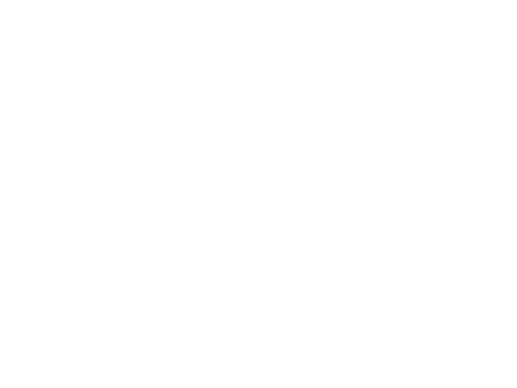

<IPython.core.display.Javascript object>


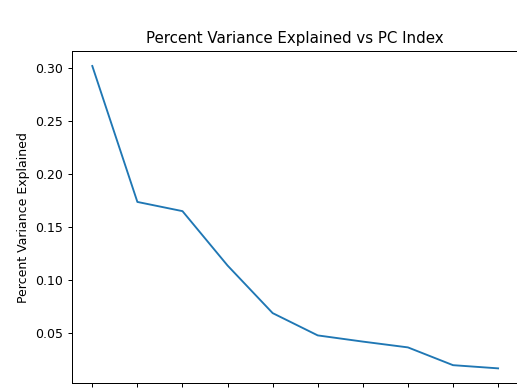

In [132]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [133]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

<IPython.core.display.Javascript object>


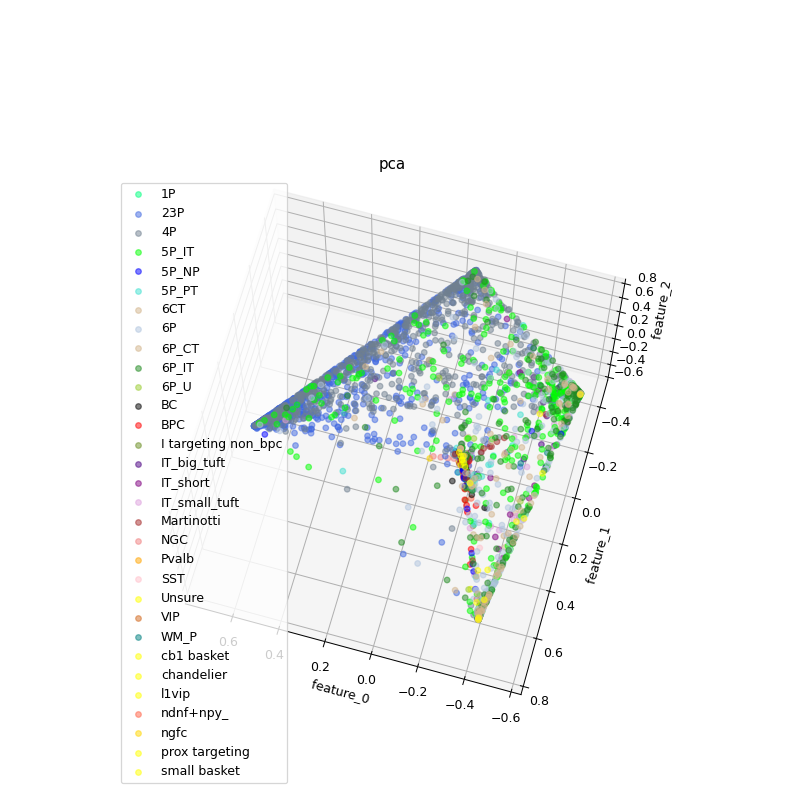

array([[ 0.09547523, -0.31983086,  0.56166541],
       [ 0.17950054, -0.20188113,  0.18083521],
       [ 0.62277618,  0.11569222, -0.23645856],
       ...,
       [-0.17975697,  0.14604378,  0.10331742],
       [-0.53876221, -0.36429719, -0.51581348],
       [-0.19005414,  0.16135784,  0.13038599]])

In [134]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
dru.dimensionality_reduction_by_method(
    method="pca",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# b) UMAP

<IPython.core.display.Javascript object>


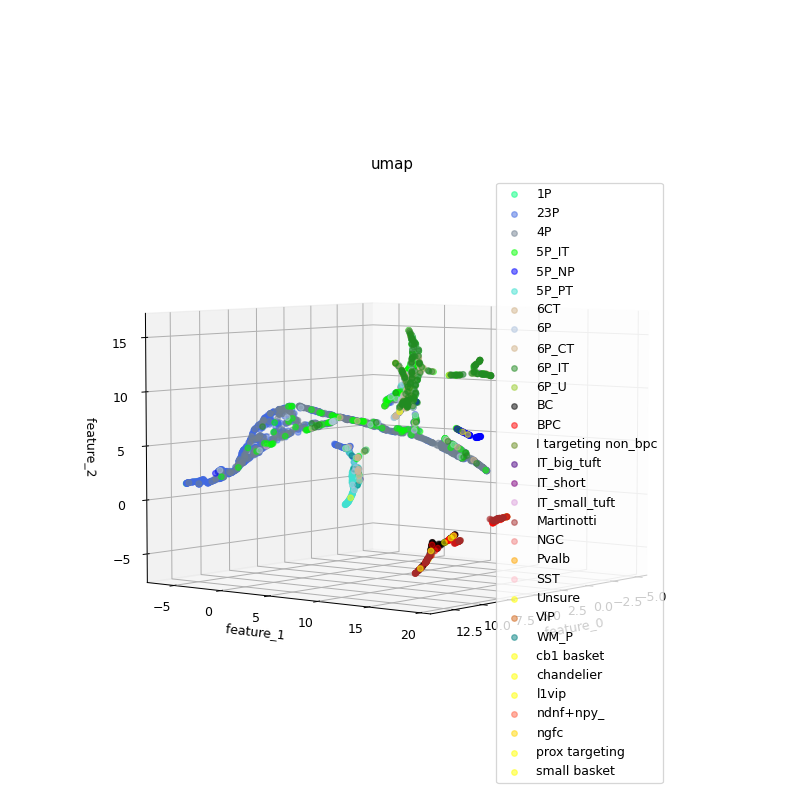

array([[-1.4017398 ,  3.0788538 ,  4.5149775 ],
       [ 2.4660141 ,  1.2173767 ,  6.4084086 ],
       [11.280087  , -0.21971515,  4.615717  ],
       ...,
       [ 7.759603  , 17.424452  ,  6.736226  ],
       [ 4.613768  ,  8.336739  , 13.26119   ],
       [ 7.4867268 , 12.74477   , -5.0943394 ]], dtype=float32)

In [135]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="umap",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


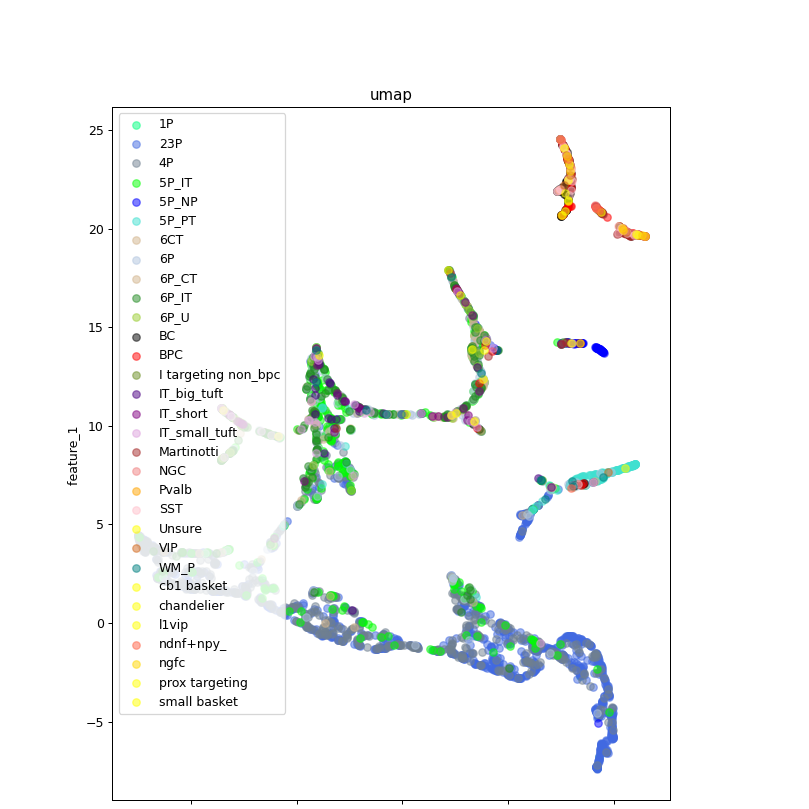

array([[-3.6077826,  1.6208935],
       [ 0.9384367,  0.6457925],
       [12.31652  , -1.6210941],
       ...,
       [13.465936 , 14.193533 ],
       [ 1.5692594, 11.906705 ],
       [12.813678 , 23.563112 ]], dtype=float32)

In [136]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="umap",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# Isomap

<IPython.core.display.Javascript object>


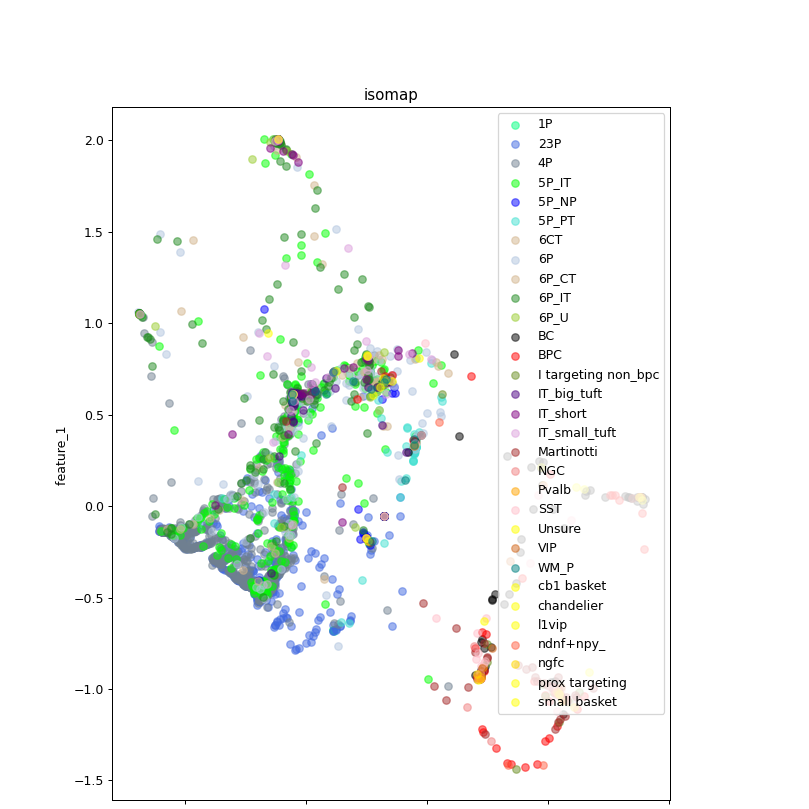

array([[-0.90628877, -0.22173147],
       [-0.45619384, -0.27722244],
       [-0.34098108, -0.42676891],
       ...,
       [ 0.49978908, -0.17666419],
       [-0.0728212 ,  0.6151807 ],
       [ 1.44522669, -0.92541808]])

In [137]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="isomap",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# TSNE

<IPython.core.display.Javascript object>


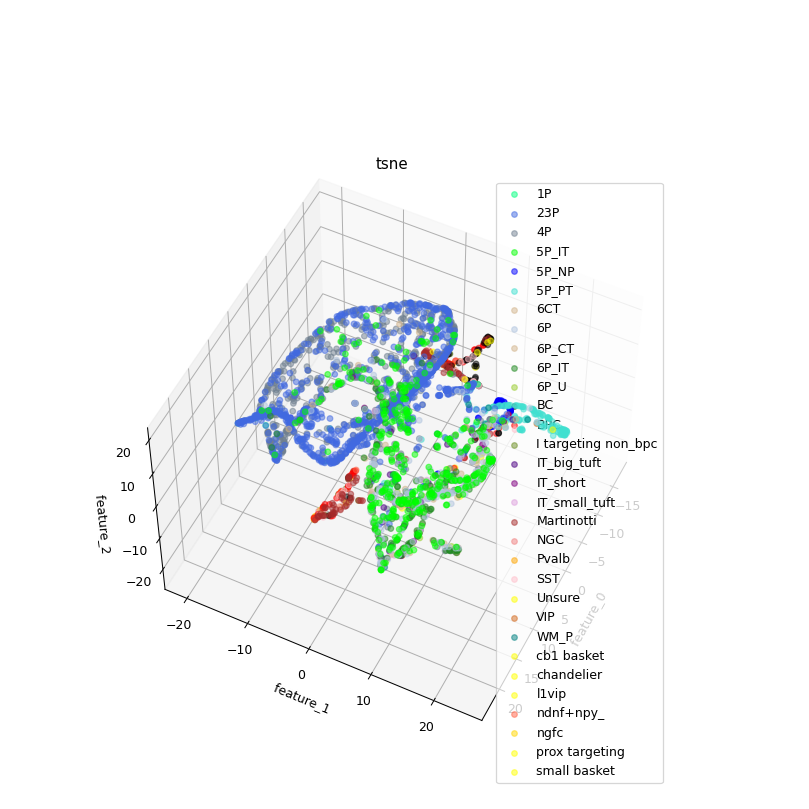

array([[  0.15885755, -15.981691  ,   9.781158  ],
       [ -6.8416348 ,  -5.6137505 ,   9.499907  ],
       [ -1.535509  ,  -7.1816735 ,  -7.78523   ],
       ...,
       [-13.862265  ,  10.9030285 , -12.794465  ],
       [ 14.659925  ,   9.089054  ,   2.839812  ],
       [ -2.7661035 ,   5.9287214 ,  18.080282  ]], dtype=float32)

In [138]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


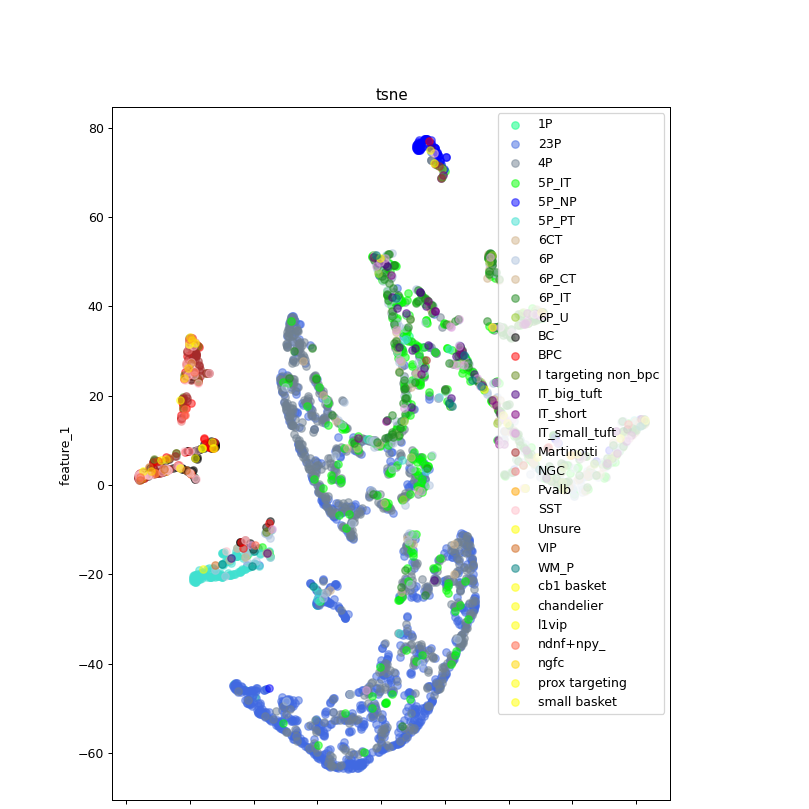

array([[-25.06847  ,   7.0454836],
       [ -6.436603 ,  -5.7713914],
       [-11.2617855, -51.152637 ],
       ...,
       [ 14.121707 ,  77.471756 ],
       [ 12.448923 ,  41.740376 ],
       [-71.497734 ,   4.069028 ]], dtype=float32)

In [139]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


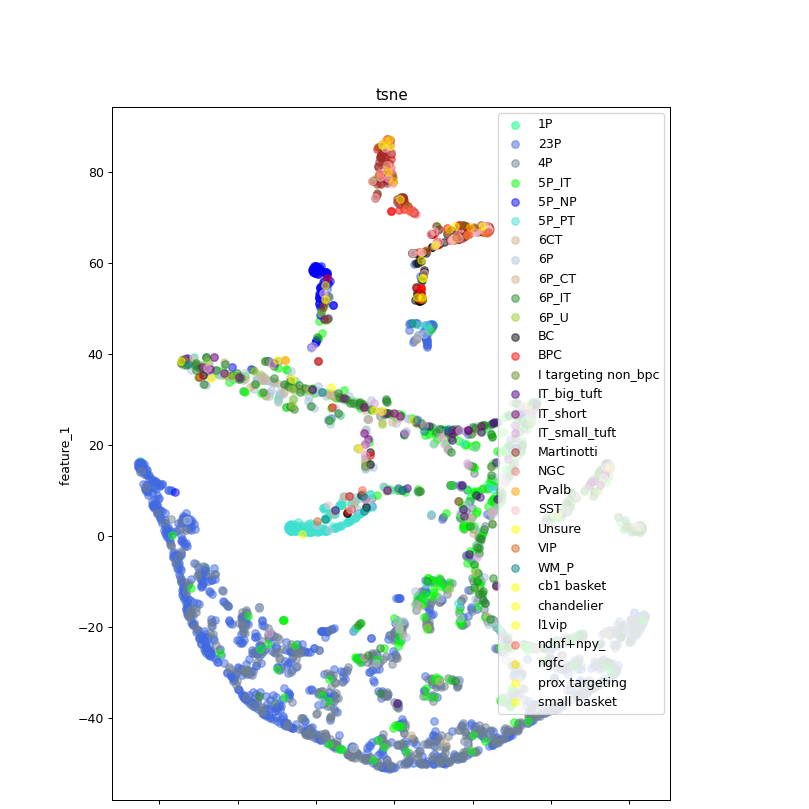

array([[ 40.491447, -38.211704],
       [ 16.922335, -41.739933],
       [-37.414135, -17.580416],
       ...,
       [-17.297258,  57.740463],
       [ 24.16309 ,  23.653284],
       [ 18.504896,  67.34053 ]], dtype=float32)

In [140]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X_pca[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)